# **Zillow Clustering Project**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import wrangle

## **Acquire Data**
-------

In [2]:
df = wrangle.get_zillow()

In [3]:
# take a look at duplicates of rows
df.duplicated().any()

False

In [4]:
# take a look at duplicates of columns
df.columns.duplicated().any()

True

In [5]:
# first drop duplicate columns from the query
df = df.loc[:, ~df.columns.duplicated()]

In [6]:
# use my get info function to get more information about the dataframe
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        222 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77381 non-null  float64
 3   heatingorsystemtypeid         49440 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      206 non-null    float64
 6   airconditioningtypeid         24953 non-null  float64
 7   parcelid                      77381 non-null  int64  
 8   transactiondate               77381 non-null  object 
 9   id                            77381 non-null  int64  
 10  basementsqft                  50 non-null     float64
 11  bathroomcnt                   77381 non-null  float64
 12  bedroomcnt                    77381 non-null  float64
 13  b

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,transactiondate,id,...,taxdelinquencyyear,censustractandblock,logerror,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
16299,NaN,NaN,261.0,2.0,NaN,NaN,1.0,10867382,2017-03-13,2343068,...,NaN,6.037142e+13,0.164219,Central,None,None,Central,Single Family Residential,None,None
48645,NaN,NaN,266.0,NaN,NaN,NaN,NaN,14602210,2017-06-21,1550093,...,NaN,6.059032e+13,0.024231,None,None,None,None,Condominium,None,None
16210,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14129530,2017-03-10,2072450,...,NaN,6.059086e+13,0.009572,None,None,None,None,Single Family Residential,None,None


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
typeconstructiontypeid,222.0,6.040541e+00,5.572847e-01,4.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,1.300000e+01
storytypeid,50.0,7.000000e+00,0.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00
propertylandusetypeid,77381.0,2.618263e+02,5.141199e+00,3.100000e+01,2.610000e+02,2.610000e+02,2.660000e+02,2.750000e+02
heatingorsystemtypeid,49440.0,3.920510e+00,3.592779e+00,1.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,2.400000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
architecturalstyletypeid,206.0,7.388350e+00,2.734542e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
airconditioningtypeid,24953.0,1.813289e+00,2.967894e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
parcelid,77381.0,1.300715e+07,3.481346e+06,1.071186e+07,1.153830e+07,1.253157e+07,1.421183e+07,1.676893e+08
id,77381.0,1.495139e+06,8.609071e+05,3.490000e+02,7.520700e+05,1.497932e+06,2.240535e+06,2.982274e+06
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03


## Acquire Takeaways
- I brought in SQL data using SQL query.
- This is a large dataset with many nulls.
- There were duplicate columns but no duplicate rows.


## **Prepare Data**
---

In [8]:
# let's take a look at the nulls in the dataframe by column
wrangle.nulls_by_column(df)

,num_rows_missing,pct_rows_missing
typeconstructiontypeid,77159,0.997131
storytypeid,77331,0.999354
propertylandusetypeid,0,0.000000
heatingorsystemtypeid,27941,0.361083
buildingclasstypeid,77366,0.999806
...,...,...
buildingclassdesc,77366,0.999806
heatingorsystemdesc,27941,0.361083
propertylandusedesc,0,0.000000
storydesc,77331,0.999354


In [9]:
# let's take a look at the nulls in the dataframe by row
wrangle.nulls_by_row(df)

,num_cols_missing,pct_cols_missing,num_rows
0,23,33.82352941176471,2
1,24,35.294117647058826,13
2,25,36.76470588235294,24
3,26,38.23529411764706,65
4,27,39.705882352941174,316
5,28,41.17647058823529,455
6,29,42.64705882352941,5270
7,30,44.11764705882353,3455
8,31,45.588235294117645,9891
9,32,47.05882352941176,12579


In [10]:
# use my drop nulls function to drop a percentage of nulls per column and row
wrangle.drop_nulls(df, .70, .70)

,propertylandusetypeid,parcelid,transactiondate,id,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,propertylandusedesc
0,261.0,14297519,2017-01-01,1727539,3.5,4.0,3.5,3100.0,3100.0,6059.0,...,0.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,Single Family Residential
1,261.0,17052889,2017-01-01,1387261,1.0,2.0,1.0,1465.0,1465.0,6111.0,...,5.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,Single Family Residential
2,261.0,14186244,2017-01-01,11677,2.0,3.0,2.0,1243.0,1243.0,6059.0,...,6.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,Single Family Residential
3,261.0,12177905,2017-01-01,2288172,3.0,4.0,3.0,2376.0,2376.0,6037.0,...,0.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,Single Family Residential
4,266.0,10887214,2017-01-01,1970746,3.0,3.0,3.0,1312.0,1312.0,6037.0,...,0.0,1964.0,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,0.006940,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77376,261.0,11000655,2017-09-20,673515,2.0,2.0,2.0,1286.0,1286.0,6037.0,...,0.0,1940.0,70917.0,354621.0,2016.0,283704.0,4478.43,6.037101e+13,0.020615,Single Family Residential
77377,261.0,17239384,2017-09-21,2968375,2.0,4.0,2.0,1612.0,1612.0,6111.0,...,7.0,1964.0,50683.0,67205.0,2016.0,16522.0,1107.48,6.111008e+13,0.013209,Single Family Residential
77378,261.0,12773139,2017-09-21,1843709,1.0,3.0,1.0,1032.0,1032.0,6037.0,...,0.0,1954.0,32797.0,49546.0,2016.0,16749.0,876.43,6.037434e+13,0.037129,Single Family Residential
77379,261.0,12826780,2017-09-25,1187175,2.0,3.0,2.0,1762.0,1762.0,6037.0,...,0.0,1955.0,140000.0,522000.0,2016.0,382000.0,6317.15,6.037503e+13,0.007204,Single Family Residential


In [11]:
df.dtypes

propertylandusetypeid           float64
parcelid                          int64
transactiondate                  object
id                                int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fips                            float64
fullbathcnt                     float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
propertycountylandusecode        object
rawcensustractandblock          float64
regionidcity                    float64
regionidcounty                  float64
regionidzip                     float64
roomcnt                         float64
yearbuilt                       float64
structuretaxvaluedollarcnt      float64
taxvaluedollarcnt               float64
assessmentyear                  float64
landtaxvaluedollarcnt           float64


In [12]:
# take a look at remaining columns we have to fill
df.isnull().sum()

propertylandusetypeid              0
parcelid                           0
transactiondate                    0
id                                 0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                607
calculatedfinishedsquarefeet     194
finishedsquarefeet12            3630
fips                               0
fullbathcnt                      607
latitude                           0
longitude                          0
lotsizesquarefeet               8237
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1469
regionidcounty                     0
regionidzip                       48
roomcnt                            0
yearbuilt                        261
structuretaxvaluedollarcnt       110
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              2
taxamount                          5
censustractandblock              242
l

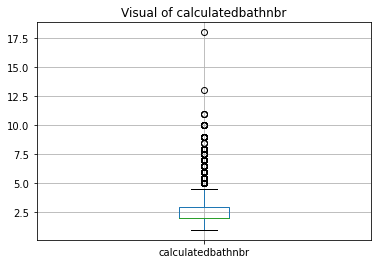

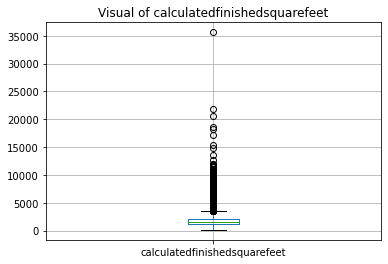

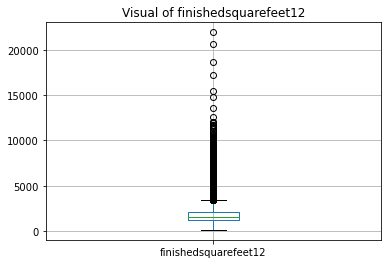

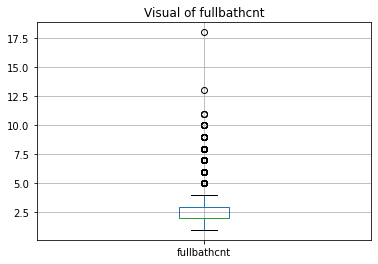

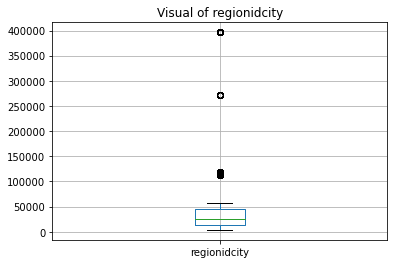

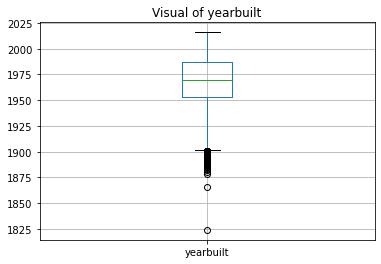

In [13]:
# show visuals for some numeral columns with nulls we need to impute
cols = df[['calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
           'fullbathcnt', 'regionidcity', 'yearbuilt']]
for i in cols:
    df.boxplot(column=[i])
    plt.title('Visual of '+i)
    plt.show()

This gives me a quick visual of how I want to impute some of my nulls. 
It also tells me there are a handful of outliers in my data I will need to address.

In [14]:
# fill my nulls using my impute function

# imputing discrete columns with most frequent value
df = wrangle.impute(df, 'most_frequent', ['calculatedfinishedsquarefeet', 'calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock'])
    
# imputing continuous columns with median value
df = wrangle.impute(df, 'median', ['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'])

In [15]:
# verify my nulls are gone
df.isnull().sum()

propertylandusetypeid           0
parcelid                        0
transactiondate                 0
id                              0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
propertylandusedesc             0
dtype: int64

In [16]:
# view and remove my outliers from the visuals above


k = 1.5 # defines the upper and lower bound threshold
numerals = df[['calculatedfinishedsquarefeet', 'calculatedbathnbr', 'fullbathcnt', 'bathroomcnt',
               'bedroomcnt', 'latitude', 'longitude', 'regionidcity', 'regionidzip', 'yearbuilt', 
               'censustractandblock', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt',
               'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']]


df = wrangle.remove_outliers(df, k, numerals)

For calculatedfinishedsquarefeet the lower bound is -205.0 and  upper bound is 3499.0
-----------------
Dataframe now has  73349 rows and  29 columns
For calculatedbathnbr the lower bound is 0.5 and  upper bound is 4.5
-----------------
Dataframe now has  73008 rows and  29 columns
For fullbathcnt the lower bound is 0.5 and  upper bound is 4.5
-----------------
Dataframe now has  73008 rows and  29 columns
For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5
-----------------
Dataframe now has  72507 rows and  29 columns
For bedroomcnt the lower bound is -1.0 and  upper bound is 7.0
-----------------
Dataframe now has  72398 rows and  29 columns
For latitude the lower bound is 33277321.25 and  upper bound is 34715847.25
-----------------
Dataframe now has  72312 rows and  29 columns
For longitude the lower bound is -119127404.125 and  upper bound is -117215613.125
-----------------
Dataframe now has  70202 rows and  29 columns
For regionidcity the lower bound is -37068.0 and 

In [17]:
df.sample(3).T

,38486,12788,56427
propertylandusetypeid,261,261,261
parcelid,12278449,12893259,11471491
transactiondate,2017-05-23,2017-02-27,2017-07-13
id,558700,24297,1062583
bathroomcnt,1,2,1
bedroomcnt,3,3,2
calculatedbathnbr,1,2,1
calculatedfinishedsquarefeet,1556,1256,948
finishedsquarefeet12,1556,1256,948
fips,6037,6037,6037


In [18]:
wrangle.value_counts(df, df.columns)

propertylandusetypeid
261.0    35611
266.0     8328
246.0     1413
269.0     1181
247.0      334
248.0      204
267.0       10
263.0       10
264.0        6
Name: propertylandusetypeid, dtype: int64
-------------
parcelid
12652542    1
14684345    1
11521363    1
10819097    1
11550029    1
           ..
14604839    1
12796573    1
11284583    1
12083865    1
10778081    1
Name: parcelid, Length: 47097, dtype: int64
-------------
transactiondate
2017-06-30    701
2017-04-28    553
2017-05-31    539
2017-07-28    481
2017-08-31    475
             ... 
2017-01-14      1
2017-08-06      1
2017-07-08      1
2017-09-21      1
2017-03-25      1
Name: transactiondate, Length: 254, dtype: int64
-------------
id
921163     1
626043     1
698276     1
234872     1
2944375    1
          ..
1155873    1
892779     1
44273      1
869149     1
1214036    1
Name: id, Length: 47097, dtype: int64
-------------
bathroomcnt
2.0    21753
1.0     9624
3.0     8915
2.5     4645
1.5     1115
4.0      857
3

Visual of distribution of bedroomcnt versus roomcnt


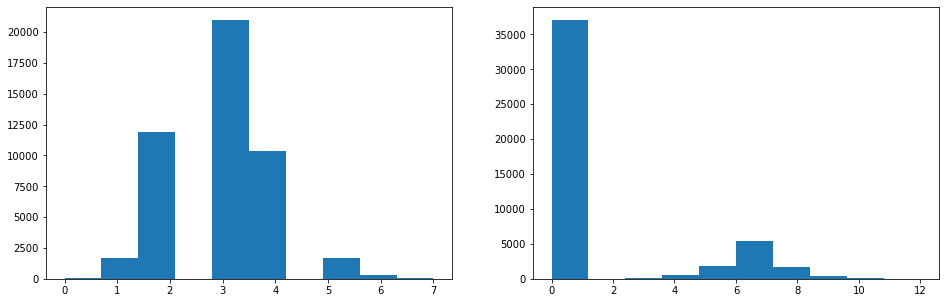

In [19]:
# visualize distributions of columns side by side to see is there are duplicates

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.bedroomcnt)
plt.subplot(122)
plt.hist(df.roomcnt);
print('Visual of distribution of bedroomcnt versus roomcnt')

Visual of distribution of fips versus regionidcounty


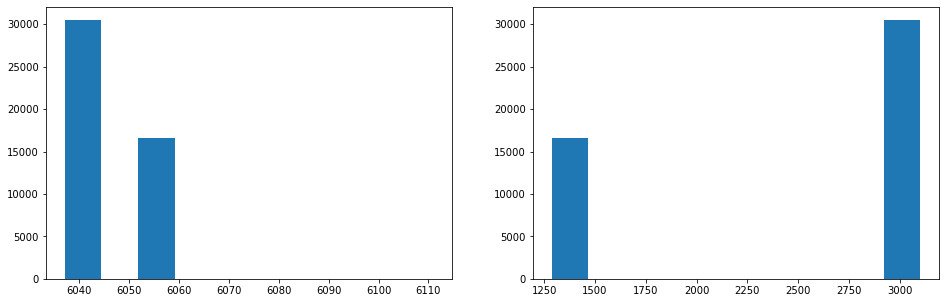

In [20]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.fips)
plt.subplot(122)
plt.hist(df.regionidcounty)
print('Visual of distribution of fips versus regionidcounty');

Visual of distribution of fullbathcnt versus bathroomcnt


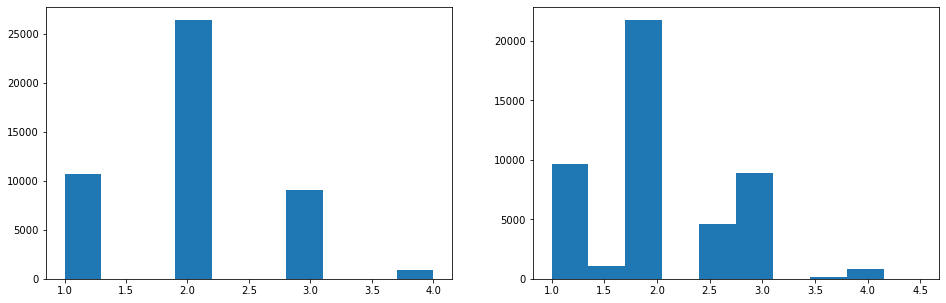

In [21]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.fullbathcnt)
plt.subplot(122)
plt.hist(df.bathroomcnt);
print('Visual of distribution of fullbathcnt versus bathroomcnt')

Visual of distribution of structuretaxvaluedollarcnt versus taxamount


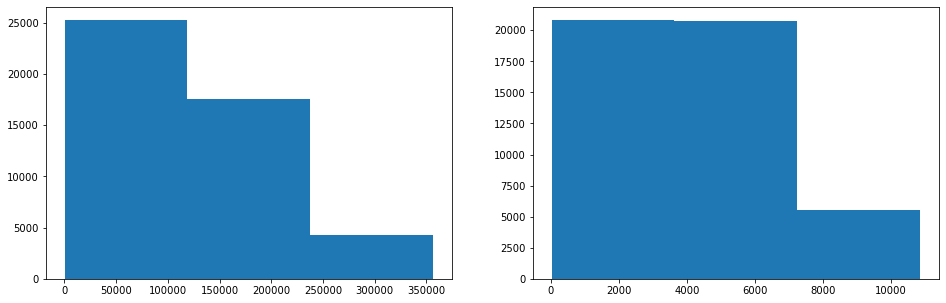

In [22]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.structuretaxvaluedollarcnt, bins=3)
plt.subplot(122)
plt.hist(df.taxamount, bins=3);
print('Visual of distribution of structuretaxvaluedollarcnt versus taxamount')

Visual of distribution of landtaxvaluedollarcnt versus taxvaluedollarcnt


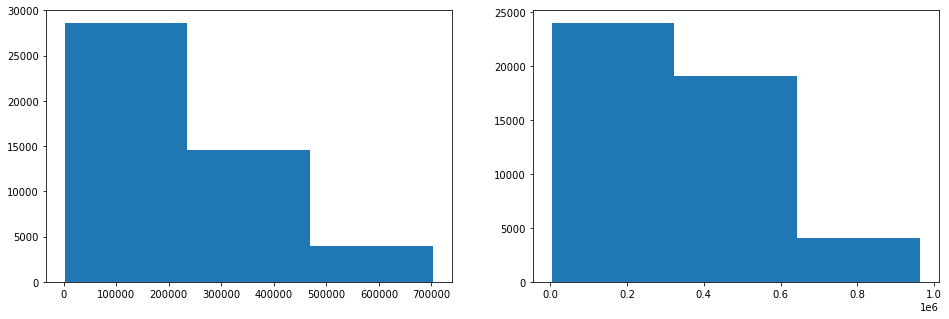

In [23]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.landtaxvaluedollarcnt, bins=3)
plt.subplot(122)
plt.hist(df.taxvaluedollarcnt, bins=3);
print('Visual of distribution of landtaxvaluedollarcnt versus taxvaluedollarcnt')

Visual of distribution of regionidcounty versus regionidcity


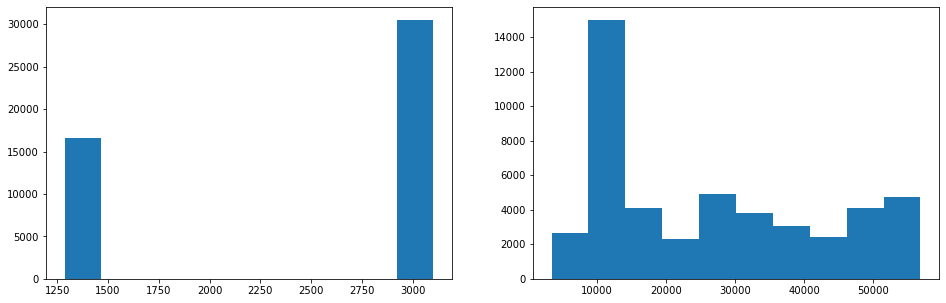

In [24]:
# might delete later

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.hist(df.regionidcounty)
plt.subplot(122)
plt.hist(df.regionidcity);
print('Visual of distribution of regionidcounty versus regionidcity')

In [25]:
# prepare and clean the dataframe using my clean_zillow funtion
df = wrangle.clean_zillow(df)

In [26]:
df.sample(8).T

,41612,33104,38855,54569,10308,27967,72921,58746
num_bathroom,2.5,2,3,2,2,2.5,2.5,2
num_bedroom,4,2,4,2,2,3,3,3
finished_sqft,2555,1161,1712,1729,847,2660,1571,1258
total_lot_sqft,5563,5291,2341,5000,7206,7344,3240,10508
zip_code,96998,96239,96962,96940,96943,96995,96948,96192
build_year,2002,1941,2014,1979,1996,1976,1980,1947
structure_tax_value,320956,71663,265048,187436,145892,198288,128202,125892
tax_value,518732,89034,692805,621658,393000,826000,689000,390422
tax_amount,8200.82,1292.34,7195.44,6391.48,4769.74,8306.42,7251.28,5994.77
log_error,-0.00462224,-0.087784,-0.0349652,0.0642591,-0.0299254,0.0115795,0.0212291,-0.0261925


In [27]:
# split my data
train, validate, test = wrangle.split_data(df)

train---> (24614, 17)
validate---> (10550, 17)
test---> (8791, 17)


In [28]:
# split my data into the X dataframe and the Y target
# X_train, y_train = train.drop(columns=['log_error', 'abs_logerr']), train['abs_logerr','log_error']
# X_validate, y_validate = validate.drop(columns=['log_error', 'abs_logerr']), validate['abs_logerr','log_error']
# X_test, y_test = test.drop(columns=['log_error', 'abs_logerr']), test['abs_logerr','log_error']

KeyError: ('abs_logerr', 'log_error')

In [29]:
# scale my data
columns_to_scale = ['finished_sqft', 'total_lot_sqft', 'structure_tax_value',
                   'tax_value', 'tax_amount']
train_scaled, validate_scaled, test_scaled = wrangle.min_max_scaler(train, validate, test, columns_to_scale)

In [ ]:
# glue our split data with our target back together for exploration
# train_scaled = pd.concat(([X_train, y_train]), axis=1)
# validate_scaled = pd.concat(([X_validate, y_validate]), axis=1)
# test_scaled = pd.concat(([X_test, y_test]), axis=1)

In [30]:
train_scaled.head().T

,29022,31878,47465,72195,9326
num_bathroom,2,1,3,1,1
num_bedroom,4,1,4,3,3
finished_sqft,0.460968,0.0932533,0.650653,0.354645,0.273402
total_lot_sqft,0.654176,0.417695,0.465505,0.408296,0.35917
zip_code,96370,97023,97078,96379,96488
build_year,1957,1964,1968,1952,1954
structure_tax_value,0.135615,0.0877067,0.412656,0.140758,0.247913
tax_value,0.0967929,0.0933532,0.391243,0.263249,0.152078
tax_amount,0.119015,0.131827,0.408235,0.291253,0.182109
log_error,0.0177247,0.257891,-0.0376018,0.00619072,-0.0466385


## Prepare Takeaways:
 - First, address my nulls by dropping and imputing.
 - Drop repetitive columns such as:
     - regionidcounty (same as FIPS)
     - fullbathcnt (same as bathroomcnt)
     - finishedsquarefeet12 (same as calculatedfinishedsquarefeet)
- Drop unnecessary columns such as:
    - roomcnt (most inputs are 0)
    - assessmentyear since all entries are 2016
- Renamed my columns to be more legible.
- Added a home_age, abs_logerr, and price_per_sqft column
- Split my data for exploration.

# Explore
---

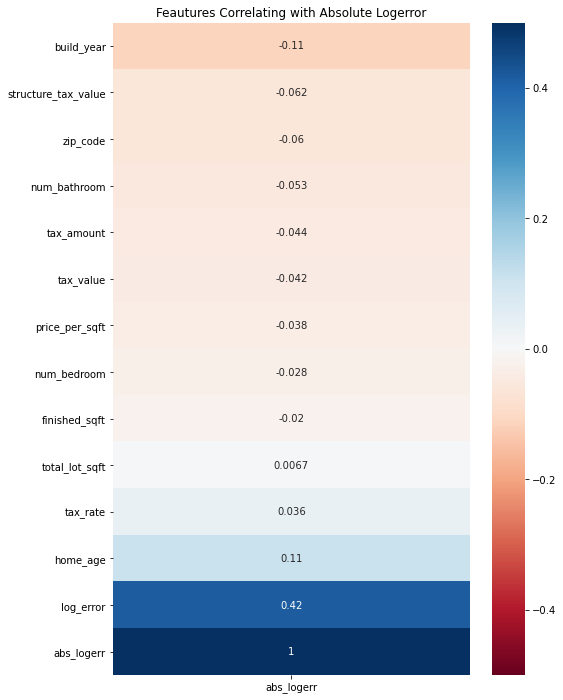

In [31]:
# Take a look at a heatmap of correlation to tax value
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train_scaled.corr()[['abs_logerr']].sort_values(by='abs_logerr', ascending=True), cmap="RdBu", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Absolute Logerror')
plt.show()

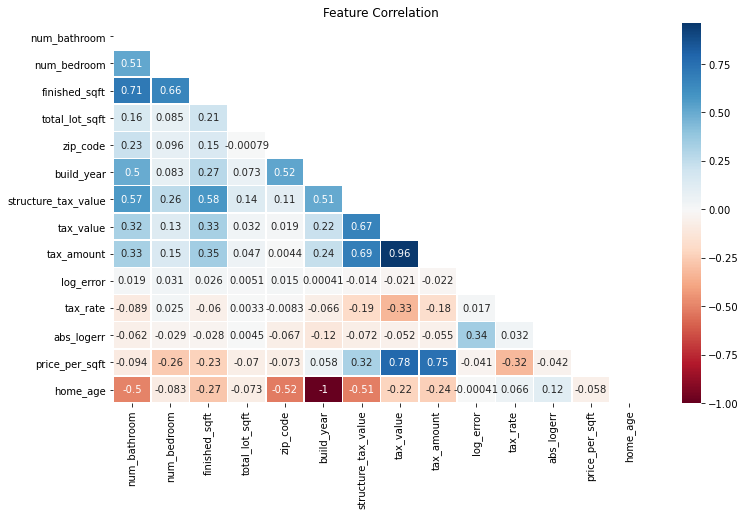

In [32]:
# Take a look at a correlation heatmap
numerical = df
corr = df.corr()
plt.figure(figsize=(12,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, annot=True, linewidths=.5, cmap="RdBu", mask=mask)
plt.title('Feature Correlation')
plt.show()

In [33]:
# take a look at value counts
wrangle.value_counts(df, df.columns)

num_bathroom
2.0    20382
1.0     9545
3.0     7619
2.5     4645
1.5     1115
4.0      461
3.5      181
4.5        7
Name: num_bathroom, dtype: int64
-------------
num_bedroom
3.0    20017
2.0    11417
4.0     9357
1.0     1617
5.0     1337
6.0      131
0.0       60
7.0       19
Name: num_bedroom, dtype: int64
-------------
finished_sqft
1200.0    141
1120.0    122
1080.0     96
1232.0     93
1400.0     91
         ... 
2669.0      1
2801.0      1
3071.0      1
505.0       1
419.0       1
Name: finished_sqft, Length: 2547, dtype: int64
-------------
total_lot_sqft
7206.0     6405
6000.0      692
5000.0      347
7200.0      266
7000.0      194
           ... 
720.0         1
12582.0       1
4032.0        1
9797.0        1
2290.0        1
Name: total_lot_sqft, Length: 9595, dtype: int64
-------------
zip_code
96987.0    596
97319.0    587
97318.0    567
96974.0    556
96993.0    550
          ... 
96039.0      2
96433.0      1
97094.0      1
97324.0      1
97344.0      1
Name: zip_code, 

In [34]:
train_scaled.head().T

,29022,31878,47465,72195,9326
num_bathroom,2,1,3,1,1
num_bedroom,4,1,4,3,3
finished_sqft,0.460968,0.0932533,0.650653,0.354645,0.273402
total_lot_sqft,0.654176,0.417695,0.465505,0.408296,0.35917
zip_code,96370,97023,97078,96379,96488
build_year,1957,1964,1968,1952,1954
structure_tax_value,0.135615,0.0877067,0.412656,0.140758,0.247913
tax_value,0.0967929,0.0933532,0.391243,0.263249,0.152078
tax_amount,0.119015,0.131827,0.408235,0.291253,0.182109
log_error,0.0177247,0.257891,-0.0376018,0.00619072,-0.0466385


Logerror versus num_bathroom


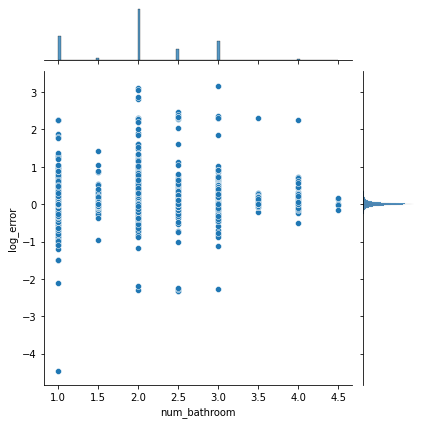

Logerror versus num_bedroom


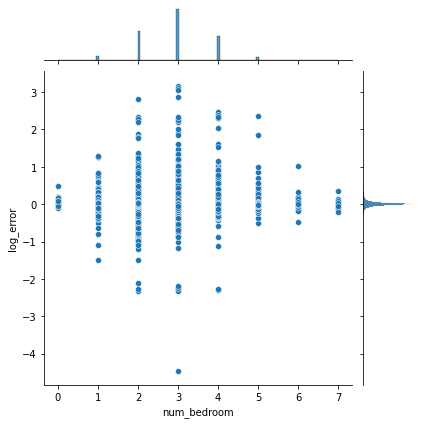

Logerror versus finished_sqft


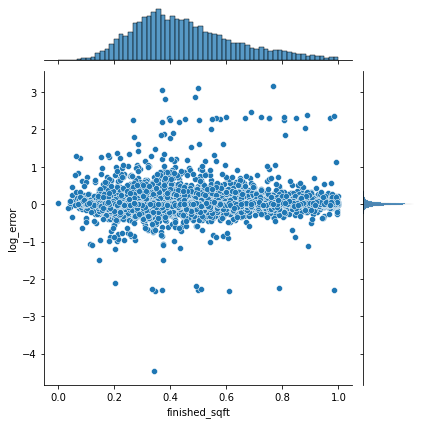

Logerror versus total_lot_sqft


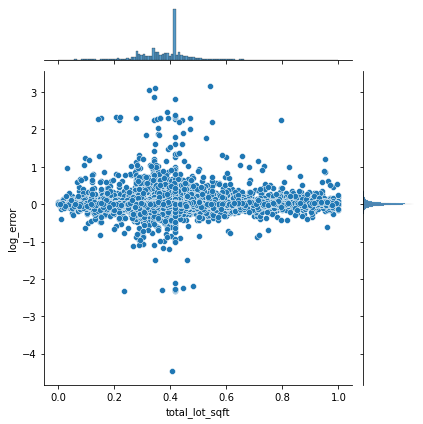

Logerror versus zip_code


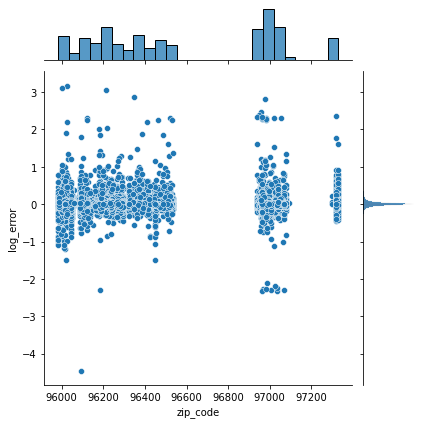

Logerror versus build_year


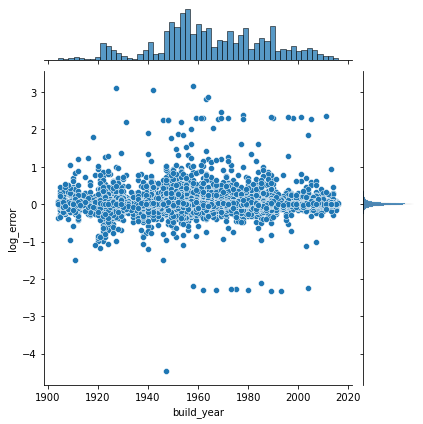

Logerror versus structure_tax_value


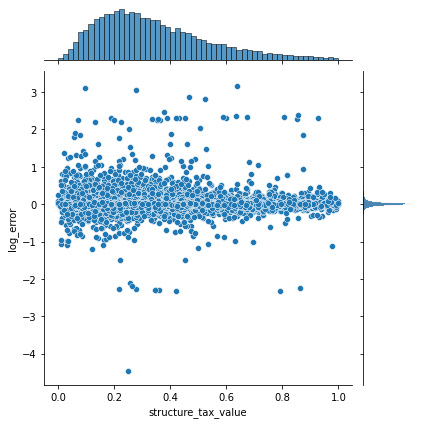

Logerror versus tax_value


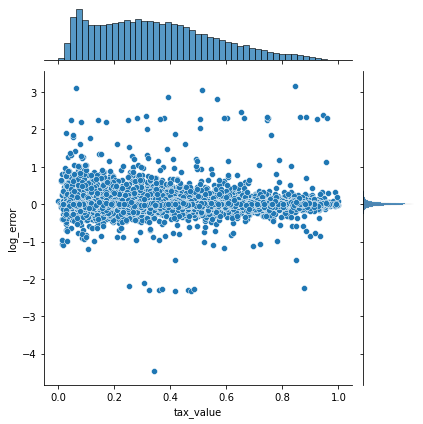

Logerror versus tax_amount


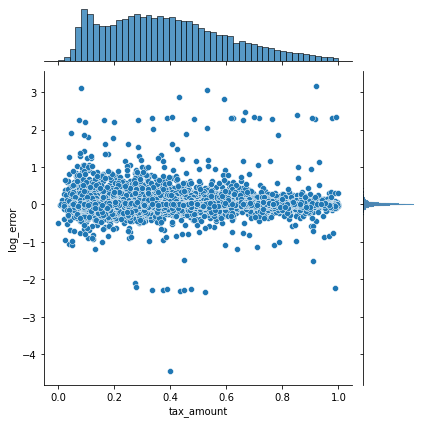

Logerror versus log_error


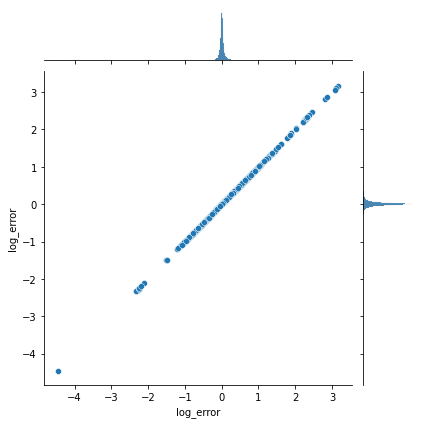

Logerror versus home_type


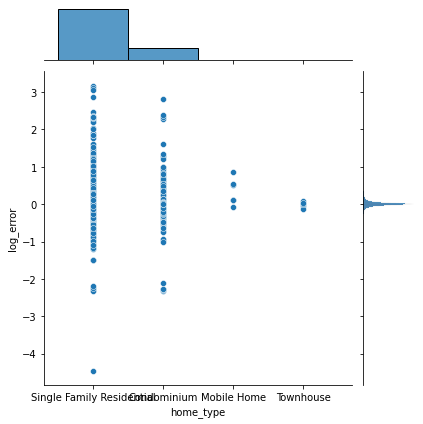

Logerror versus county


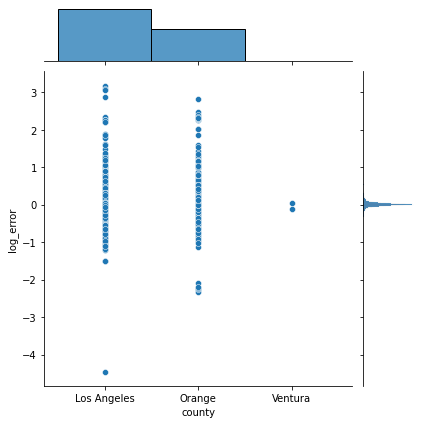

Logerror versus tax_rate


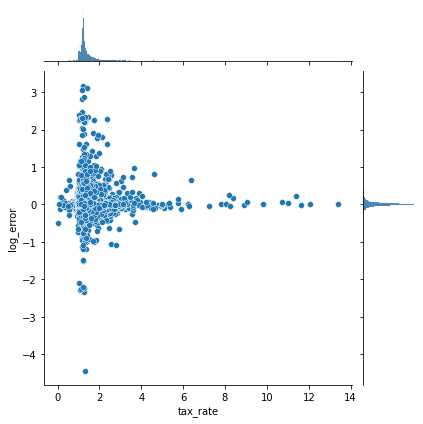

Logerror versus abs_logerr


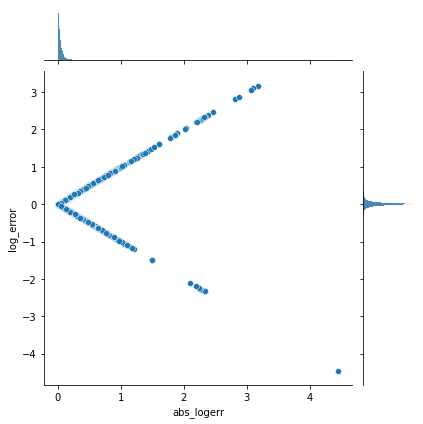

Logerror versus price_per_sqft


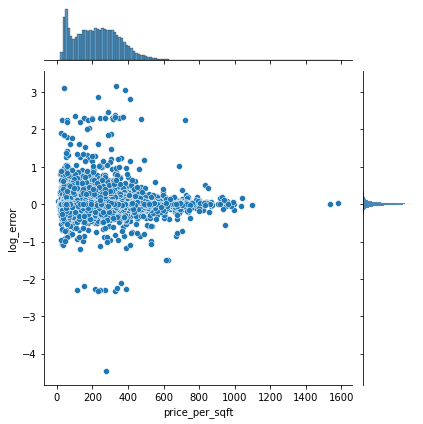

Logerror versus home_age


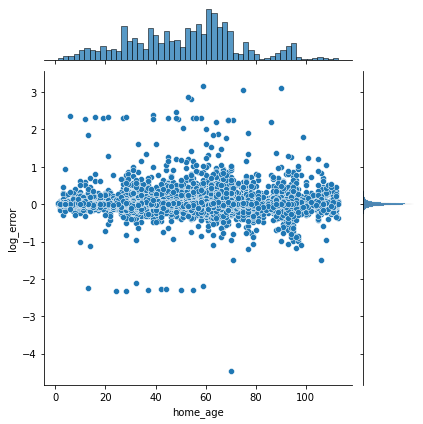

Logerror versus quadrimester


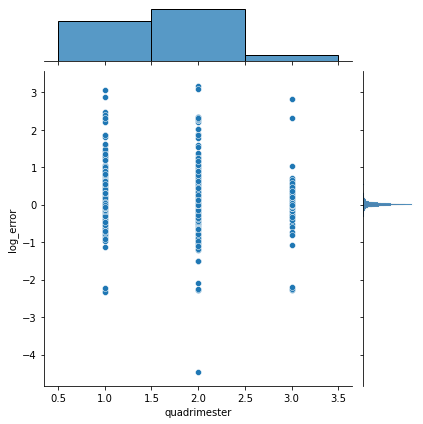

In [43]:
cols = df.columns
for i in cols:
    print('Logerror versus', i)
    sns.jointplot(x=i, y='log_error', data=train_scaled)
    plt.xlabel(i)
    plt.ylabel('Logerror')
    plt.show()

Absolute Logerror versus num_bathroom


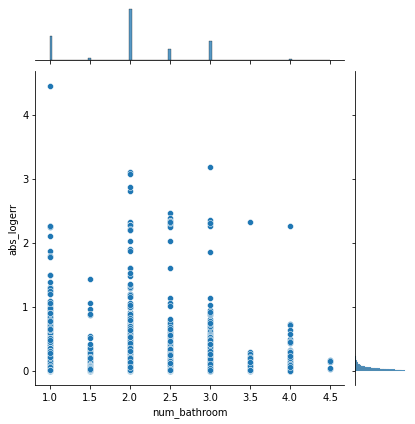

Absolute Logerror versus num_bedroom


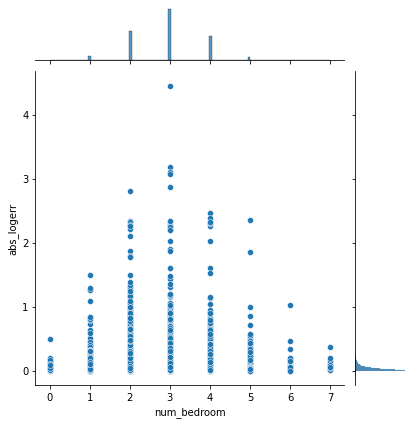

Absolute Logerror versus finished_sqft


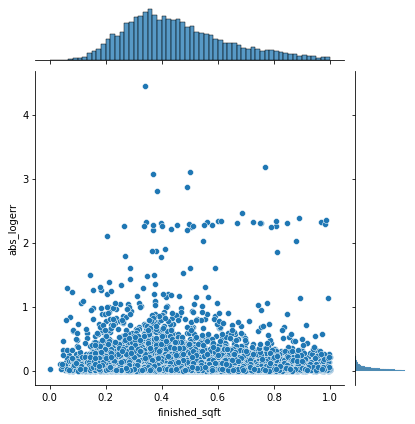

Absolute Logerror versus total_lot_sqft


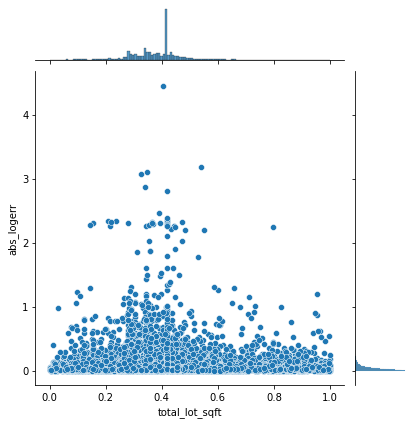

Absolute Logerror versus zip_code


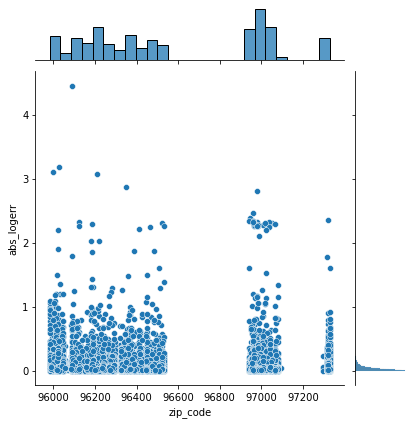

Absolute Logerror versus build_year


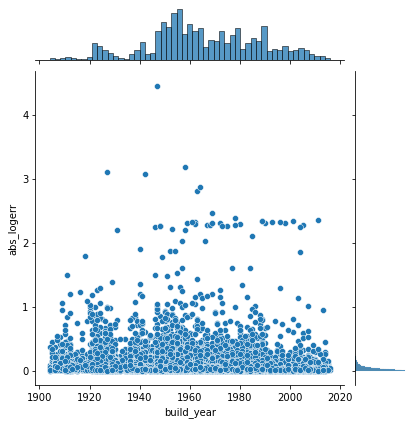

Absolute Logerror versus structure_tax_value


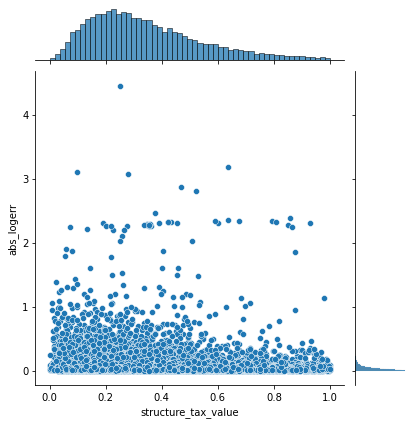

Absolute Logerror versus tax_value


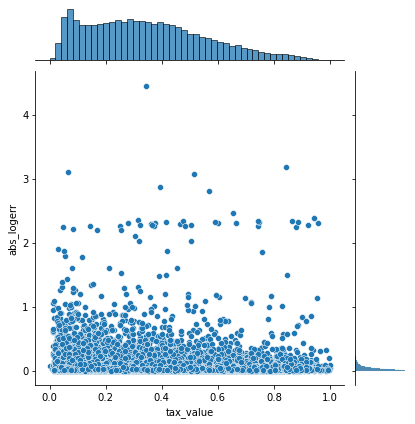

Absolute Logerror versus tax_amount


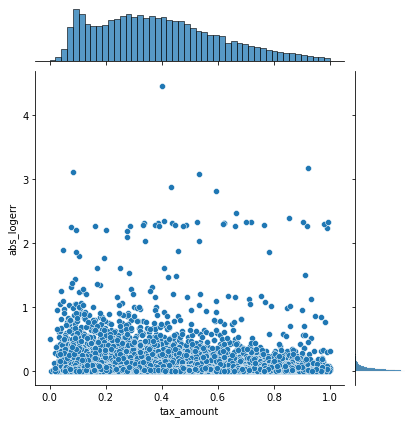

Absolute Logerror versus log_error


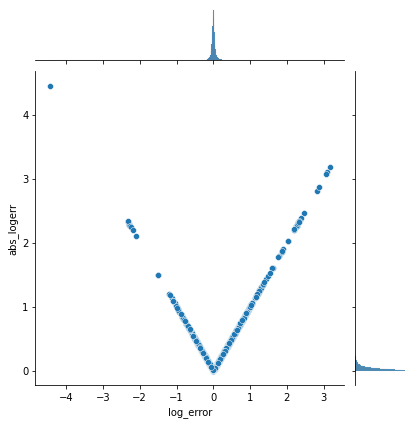

Absolute Logerror versus home_type


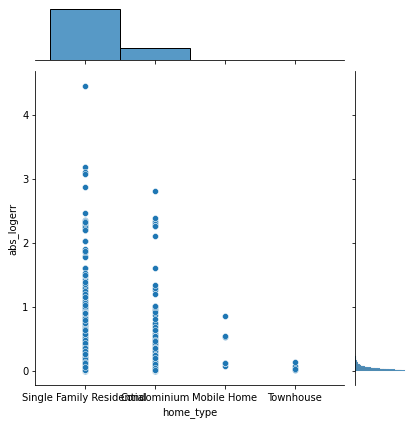

Absolute Logerror versus county


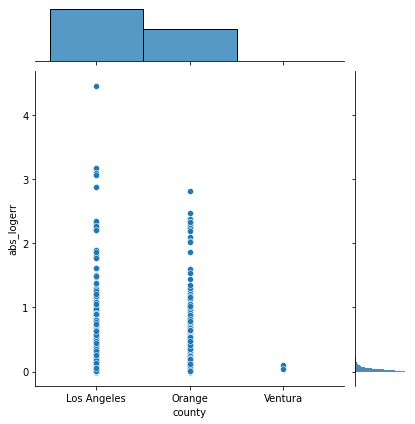

Absolute Logerror versus tax_rate


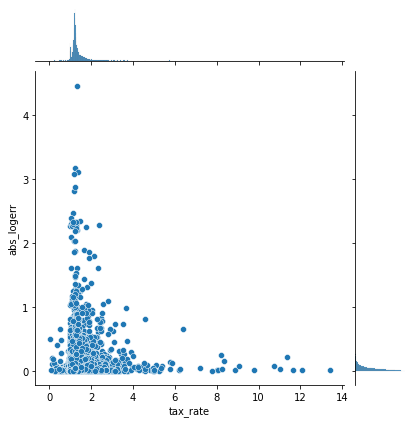

Absolute Logerror versus abs_logerr


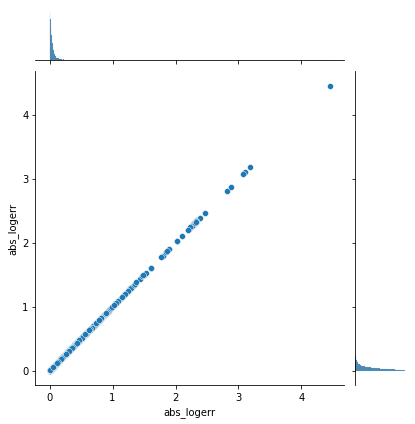

Absolute Logerror versus price_per_sqft


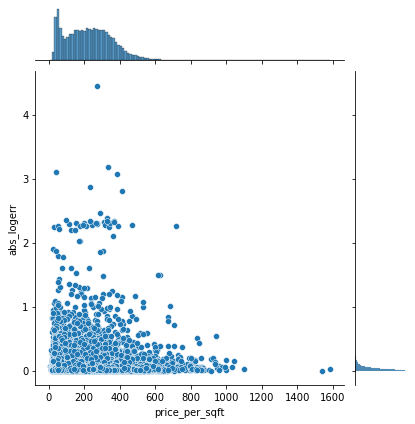

Absolute Logerror versus home_age


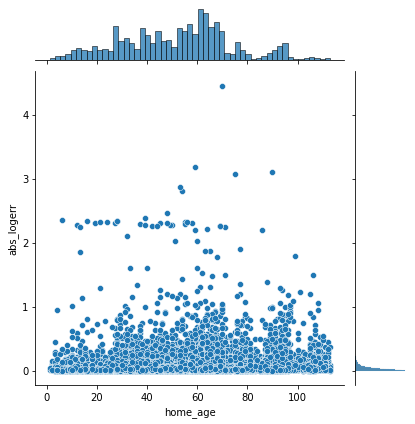

Absolute Logerror versus quadrimester


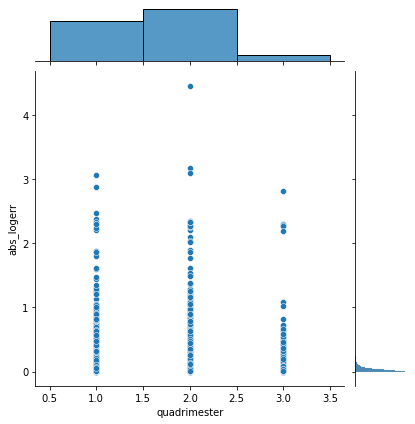

In [42]:
cols = df.columns
for i in cols:
    print('Absolute Logerror versus', i)
    sns.jointplot(x=i, y='abs_logerr', data=train_scaled)
    plt.xlabel(i)
    plt.ylabel('Absolute Logerror')
    plt.show()